# GIBBS SAMPLER


## Simple independent distrib

bivariate normal distribution with density p(x,y) that has very different variances for each variable

In [4]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

np.random.seed(42)

def log_gaussian(x, mu, sigma):
    # The np.sum() is for compatibility with sample_MH
    return - 0.5 * np.sum((x - mu) ** 2) / sigma ** 2 \
           - np.log(np.sqrt(2 * np.pi * sigma ** 2))


class BivariateNormal(object):
    n_variates = 2

    def __init__(self, mu1, mu2, sigma1, sigma2):
        self.mu1, self.mu2 = mu1, mu2
        self.sigma1, self.sigma2 = sigma1, sigma2

    def log_p_x(self, x):
        return log_gaussian(x, self.mu1, self.sigma1)

    def log_p_y(self, x):
        return log_gaussian(x, self.mu2, self.sigma2)

    def log_prob(self, x):
        cov_matrix = np.array([[self.sigma1 ** 2, 0],
                               [0, self.sigma2 ** 2]])
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        kernel = -0.5 * (x - self.mu1) @ inv_cov_matrix @ (x - self.mu2).T
        normalization = np.log(np.sqrt((2 * np.pi) ** self.n_variates * np.linalg.det(cov_matrix)))

        return kernel - normalization


bivariate_normal = BivariateNormal(mu1=0.0, mu2=0.0, sigma1=1.0, sigma2=0.15)

In [6]:
bivariate_normal

plot it

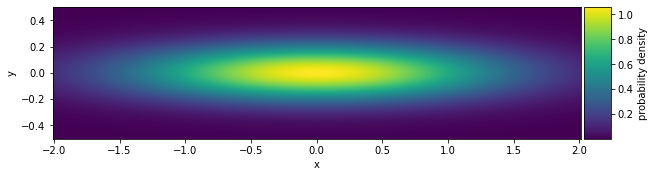

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
xses = np.linspace(-2, 2, 200)
yses = np.linspace(-0.5, 0.5, 200)
log_density_values = [[bivariate_normal.log_prob(np.array((x, y))) for x in xses] for y in yses]
dx = (xses[1] - xses[0]) / 2
dy = (yses[1] - yses[0]) / 2
extent = [xses[0] - dx, xses[-1] + dx, yses[0] - dy, yses[-1] + dy]
im = ax.imshow(np.exp(log_density_values), extent=extent)
ax.set_xlabel('x')
ax.set_ylabel('y')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im, cax=cax)
cb.set_label('probability density')
plt.show()

## Systematic scan gibbs sampler

Use of P Metropolis-Hasting acceptance/reject process

In [16]:
def sample_MH(x_old, log_prob, stepsize):
    x_new = proposal(x_old, stepsize)
    # here we determine whether we accept the new state or not:
    # we draw a random number uniformly from [0,1] and compare
    # it with the acceptance probability
    accept = np.random.random() < p_acc_MH(x_new, x_old, log_prob)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

def p_acc_MH(x_new, x_old, log_prob):
    return min(1, np.exp(log_prob(x_new) - log_prob(x_old)))

def log_prob(x):
     return -0.5 * np.sum(x ** 2)
    
def proposal(x, stepsize):
    return np.random.uniform(low=x - 0.5 * stepsize,
                             high=x + 0.5 * stepsize,
                             size=x.shape)
   

Variables have independent step size

In [17]:
def sample_gibbs(old_state, bivariate_dist, stepsizes):
    """Draws a single sample using the systematic Gibbs sampling
    transition kernel

    Arguments:
    - old_state: the old (two-dimensional) state of a Markov chain
                 (a list containing two floats)
    - bivariate_dist: an object representing a bivariate distribution
                      (in our case, an instance of BivariateNormal)
    - stepsizes: a list of step sizes

    """
    x_old, y_old = old_state

    # for compatibility with sample_MH, change floats to one-dimensional
    # numpy arrays of length one
    x_old = np.array([x_old])
    y_old = np.array([y_old])

    # draw new x conditioned on y
    p_x_y = bivariate_dist.log_p_x
    accept_x, x_new = sample_MH(x_old, p_x_y, stepsizes[0])

    # draw new y conditioned on x
    p_y_x = bivariate_dist.log_p_y
    accept_y, y_new = sample_MH(y_old, p_y_x, stepsizes[1])

    # Don't forget to turn the one-dimensional numpy arrays x_new, y_new
    # of length one back into floats

    return (accept_x, accept_y), (x_new[0], y_new[0])

In [18]:
def build_gibbs_chain(init, stepsizes, n_total, bivariate_dist):
    """Builds a Markov chain by performing repeated transitions using
    the systematic Gibbs sampling transition kernel

    Arguments:
    - init: an initial (two-dimensional) state for the Markov chain
            (a list containing two floats)
    - stepsizes: a list of step sizes of type float
    - n_total: the total length of the Markov chain
    - bivariate_dist: an object representing a bivariate distribution
                      (in our case, an instance of BivariateNormal)

    """
    init_x, init_k = init
    chain = [init]
    acceptances = []

    for _ in range(n_total):
        accept, new_state = sample_gibbs(chain[-1], bivariate_dist, stepsizes)
        chain.append(new_state)
        acceptances.append(accept)

    acceptance_rates = np.mean(acceptances, 0)
    print("Acceptance rates: x: {:.3f}, y: {:.3f}".format(acceptance_rates[0],
                                                          acceptance_rates[1]))

    return chain

stepsizes = (6.5, 1.0)
initial_state = [2.0, -1.0]
chain = build_gibbs_chain(initial_state, stepsizes, 100000, bivariate_normal)
chain = np.array(chain)

Acceptance rates: x: 0.461, y: 0.458


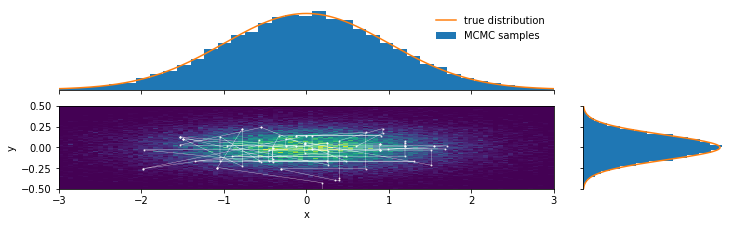

In [22]:
def plot_samples(chain, log_prob, ax, orientation='vertical', normalize=True,
                 xlims=(-5, 5), legend=True):
    from scipy.integrate import quad

    ax.hist(chain, bins=50, density=True, label="MCMC samples",
           orientation=orientation)
    # we numerically calculate the normalization constant of our PDF
    if normalize:
        Z, _ = quad(lambda x: np.exp(log_prob(x)), -np.inf, np.inf)
    else:
        Z = 1.0
    xses = np.linspace(xlims[0], xlims[1], 1000)
    yses = [np.exp(log_prob(x)) / Z for x in xses]
    if orientation == 'horizontal':
        (yses, xses) = (xses, yses)
    ax.plot(xses, yses, label="true distribution")
    if legend:
        ax.legend(frameon=False)
def plot_samples_2D(chain, path_length, burnin, ax, xlims=(-3, 3), ylims=(-0.5, 0.5)):
    chain = np.array(chain)
    bins = [np.linspace(xlims[0], xlims[1], 100), np.linspace(ylims[0], ylims[1], 100)]
    ax.hist2d(*chain[burnin:].T, bins=bins)
    ax.plot(*chain[:path_length].T, marker='o', c='w', lw=0.4, 
            markersize=1, alpha=0.75)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    
def plot_bivariate_samples(chain, burnin, pdf):
    fig = plt.figure(figsize=(12,7))
   
    ax_c = plt.subplot2grid((4, 4), (1, 0), rowspan=1, colspan=3)
    plot_samples_2D(chain, 100, burnin, ax_c)
    
    ax_t = plt.subplot2grid((4, 4), (0, 0), rowspan=1, colspan=3, sharex=ax_c)
    plot_samples(chain[:,0], pdf.log_p_x, ax_t, normalize=False)
    plt.setp(ax_t.get_xticklabels(), visible=False)
    ax_t.set_yticks(())
    for spine in ('top', 'left', 'right'):
        ax_t.spines[spine].set_visible(False)

    ax_r = plt.subplot2grid((4, 4), (1, 3), rowspan=1, colspan=1, sharey=ax_c)
    plot_samples(chain[:,1], pdf.log_p_y, ax_r, orientation='horizontal',
                 normalize=False, legend=False)
    plt.setp(ax_r.get_yticklabels(), visible=False)
    ax_r.set_xticks(())
    for spine in ('top', 'bottom', 'right'):
        ax_r.spines[spine].set_visible(False)

    plt.show()
    
plot_bivariate_samples(chain, burnin=200, pdf=bivariate_normal)

## Complex exemple 

In [26]:
mix_params = dict(mu1=1.0, mu2=2.0, sigma1=0.5, sigma2=0.2, w1=0.3, w2=0.7)

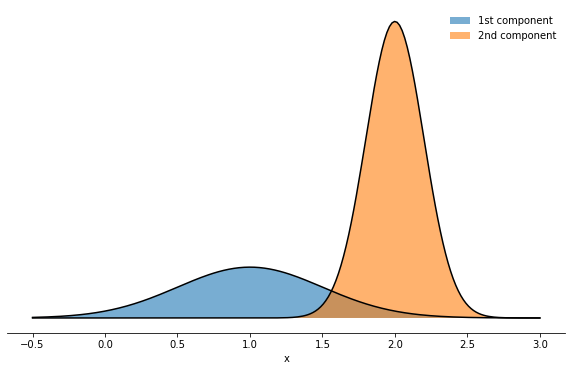

In [27]:
fig, ax = plt.subplots()
xspace = np.linspace(-0.5, 3, 200)

# densities of both components
first_component = [np.exp(log_gaussian(x, mix_params['mu1'], mix_params['sigma1']))
                   for x in xspace]
second_component = [np.exp(log_gaussian(x, mix_params['mu2'], mix_params['sigma2']))
                    for x in xspace]

# apply component weights
first_component = mix_params['w1'] * np.array(first_component)
second_component = mix_params['w2'] * np.array(second_component)

ax.plot(xspace, first_component, color='black')
ax.fill_between(xspace, first_component, alpha=0.6, label="1st component")
ax.plot(xspace, second_component, color='black')
ax.fill_between(xspace, second_component, alpha=0.6, label="2nd component")
ax.set_xlabel('x')
ax.set_yticks(())
ax.legend(frameon=False)
for spine in ('top', 'left', 'right'):
    ax.spines[spine].set_visible(False)
plt.show()

Gaussian mixture

In [28]:
class GaussianMixture(object):

    def __init__(self, mu1, mu2, sigma1, sigma2, w1, w2):
        self.mu1, self.mu2 = mu1, mu2
        self.sigma1, self.sigma2 = sigma1, sigma2
        self.w1, self.w2 = w1, w2

    def log_prob(self, x):
        return np.logaddexp(np.log(self.w1) + log_gaussian(x, self.mu1, self.sigma1),
                            np.log(self.w2) + log_gaussian(x, self.mu2, self.sigma2))

    def log_p_x_k(self, x, k):
        # logarithm of p(x|k)
        mu = (self.mu1, self.mu2)[k]
        sigma = (self.sigma1, self.sigma2)[k]

        return log_gaussian(x, mu, sigma)

    def p_k_x(self, k, x):
        # p(k|x) using Bayes' theorem
        mu = (self.mu1, self.mu2)[k]
        sigma = (self.sigma1, self.sigma2)[k]
        weight = (self.w1, self.w2)[k]
        log_normalization = self.log_prob(x)

        return np.exp(log_gaussian(x, mu, sigma) + np.log(weight) - log_normalization)

We need to adapt sampling method for k discrete variable 

In [29]:
def sample_gibbs(old_state, mixture, stepsize):
    """Draws a single sample using the systematic Gibbs sampling
    transition kernel

    Arguments:
    - old_state: the old (two-dimensional) state of a Markov chain
                 (a list containing a float and an integer representing
                 the initial mixture component)
    - mixture: an object representing a mixture of densities
               (in our case, an instance of GaussianMixture)
    - stepsize: a step size of type float

    """
    x_old, k_old = old_state

    # for compatibility with sample_MH, change floats to one-dimensional
    # numpy arrays of length one
    x_old = np.array([x_old])

    # draw new x conditioned on k
    x_pdf = lambda x: mixture.log_p_x_k(x, k_old)
    accept, x_new = sample_MH(x_old, x_pdf, stepsize)

    # ... turn the one-dimensional numpy arrays of length one back
    # into floats
    x_new = x_new[0]

    # draw new k conditioned on x
    k_probabilities = (mixture.p_k_x(0, x_new), mixture.p_k_x(1, x_new))
    jump_probability = k_probabilities[1 - k_old]
    k_new = np.random.choice((0,1), p=k_probabilities)

    return accept, jump_probability, (x_new, k_new)


def build_gibbs_chain(init, stepsize, n_total, mixture):
    """Builds a Markov chain by performing repeated transitions using
    the systematic Gibbs sampling transition kernel

    Arguments:
    - init: an initial (two-dimensional) state of a Markov chain
            (a list containing a one-dimensional numpy array
            of length one and an integer representing the initial
            mixture component)
    - stepsize: a step size of type float
    - n_total: the total length of the Markov chain
    - mixture: an object representing a mixture of densities
               (in our case, an instance of GaussianMixture)

    """
    init_x, init_k = init
    chain = [init]
    acceptances = []
    jump_probabilities = []

    for _ in range(n_total):
        accept, jump_probability, new_state = sample_gibbs(chain[-1], mixture, stepsize)
        chain.append(new_state)
        jump_probabilities.append(jump_probability)
        acceptances.append(accept)

    acceptance_rates = np.mean(acceptances)
    print("Acceptance rate: x: {:.3f}".format(acceptance_rates))
    print("Average probability to change mode: {}".format(np.mean(jump_probabilities)))

    return chain

mixture = GaussianMixture(**mix_params)
stepsize = 1.0
initial_state = [2.0, 1]
chain = build_gibbs_chain(initial_state, stepsize, 10000, mixture)
burnin = 1000
x_states = [state[0] for state in chain[burnin:]]

Acceptance rate: x: 0.635
Average probability to change mode: 0.07962342293744887


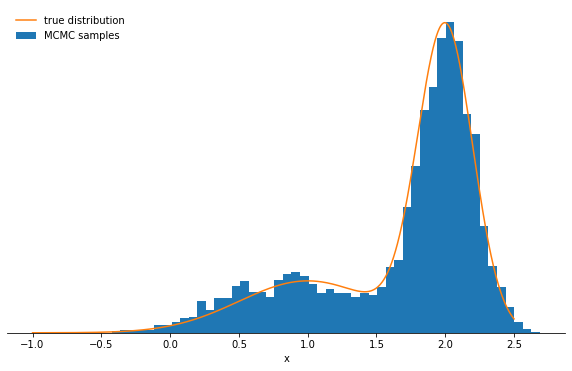

In [44]:
fig, ax = plt.subplots()
plot_samples(x_states, mixture.log_prob, ax, normalize=False, xlims=(-1,2.5))
for spine in ('top', 'left', 'right'):
    ax.spines[spine].set_visible(False)
ax.set_yticks(())
ax.set_xlabel('x')
plt.show()

In [40]:
mixture